In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load ECG Dataset

The ECG heartbeats datasets contains a patient's (with ID $71$) heartbeat from the LTAF database. It consists of $3.000$ measurements at $128Hz$ corresponding to roughly $~23s$. The heartbeat rate is around $60$ to $80$ bpm. The TS contains two motifs. It starts with $6$ repetitions of a calibration signal, followed by roughly $16$ full heartbeats.

### References
- [1] https://academic.oup.com/europace/article/9/7/466/553888

Dataset Original Length n:  3000
Dataset Sampled Length n:  3000
../datasets/ground_truth/ecg-heartbeat-av_gt.csv


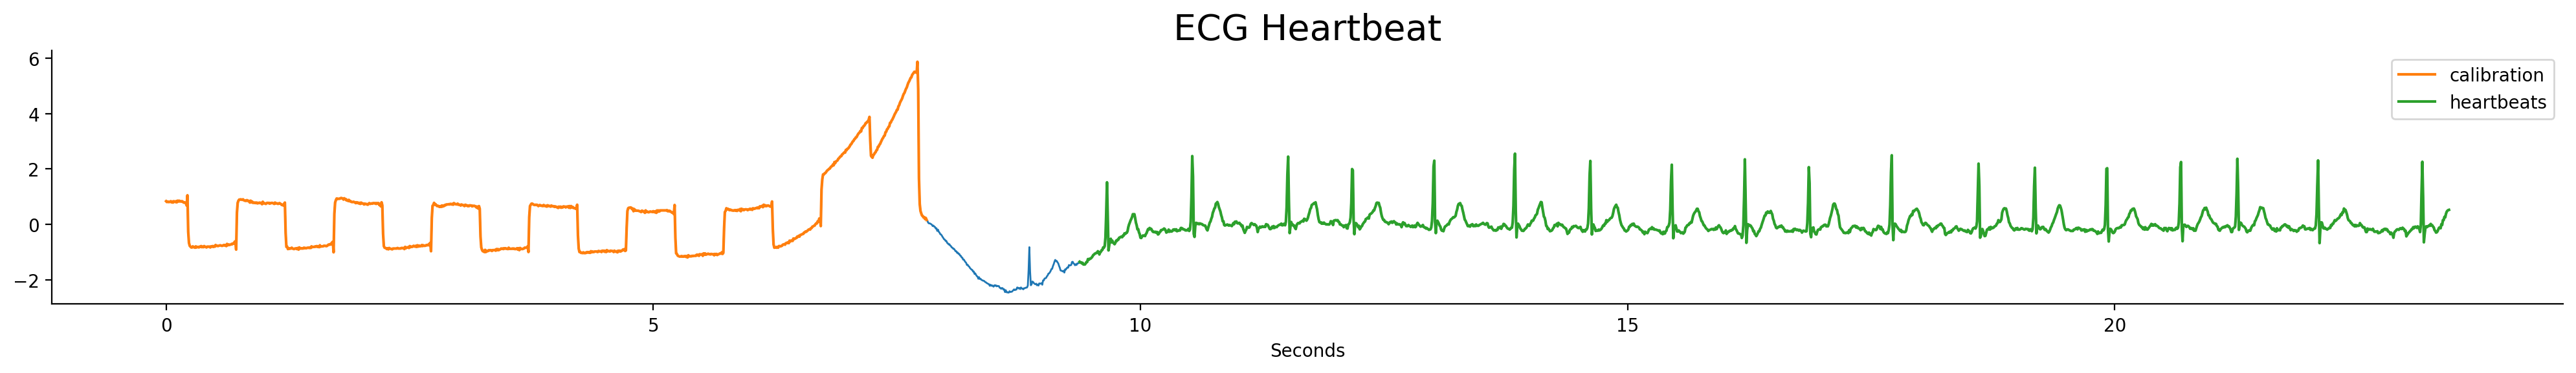

(<Figure size 2000x300 with 1 Axes>,
 [<Axes: title={'center': 'ECG Heartbeat'}, xlabel='Seconds'>])

In [2]:
ds_name = "ECG Heartbeat"
file = 'ecg-heartbeat-av.csv'
series, df_gt = ml.read_dataset_with_index(file)
plot_dataset(ds_name, series, ground_truth=df_gt)

# Known Motifs

There are two motifs: A calibration signal with $6$ repetitions, and the actual heartbeats with around $16$ occurrences.

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1 motifs
df2 = pd.DataFrame() # TOP-2 motifs
rerun_all_jars = False
ks=20
dataset = os.getcwd() + '/../datasets/' + file

# k-Motiflets

## First, we learn the motif length l

We find aminimum around $l=0.8s$ to $l=1s$, equal to a heartbeat rate of $60$-$80$ bpm. 

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

	Time 0.7 s


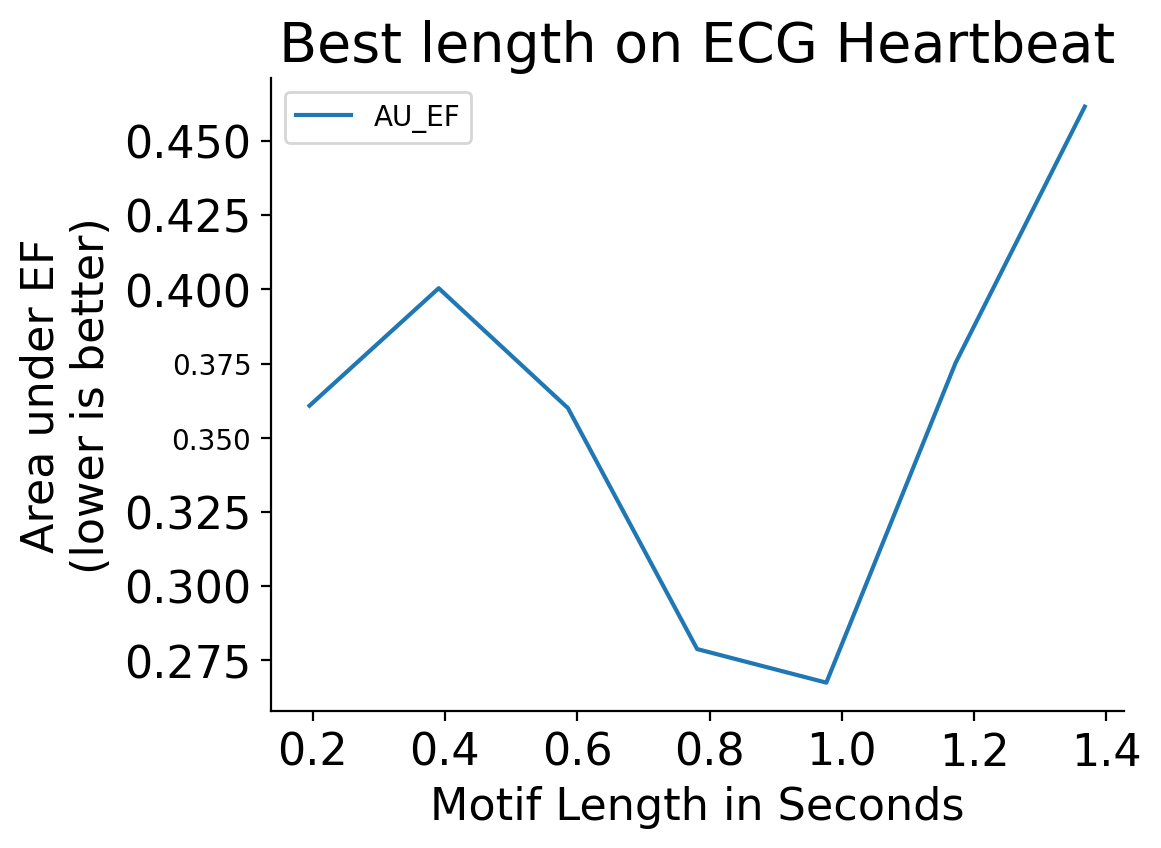

Best motif length 0.9765625 seconds


In [4]:
length_range = np.arange(25,200,25) 
motif_length = plot_motif_length_selection(
    ks,
    series,
    motif_length_range=length_range,
    ds_name=ds_name)

print ("Best motif length", series.index[motif_length], "seconds")

## Next, we learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change from calibrations signal to heartbeats.

In the following plots, we found two characteristic motifs: calibration waves with $6$ repetitions and heartbeats with $16$ repetitions.

Data 3000


Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Chosen window-size: 125 in 0.3 s
Elbow Points [ 6 16]


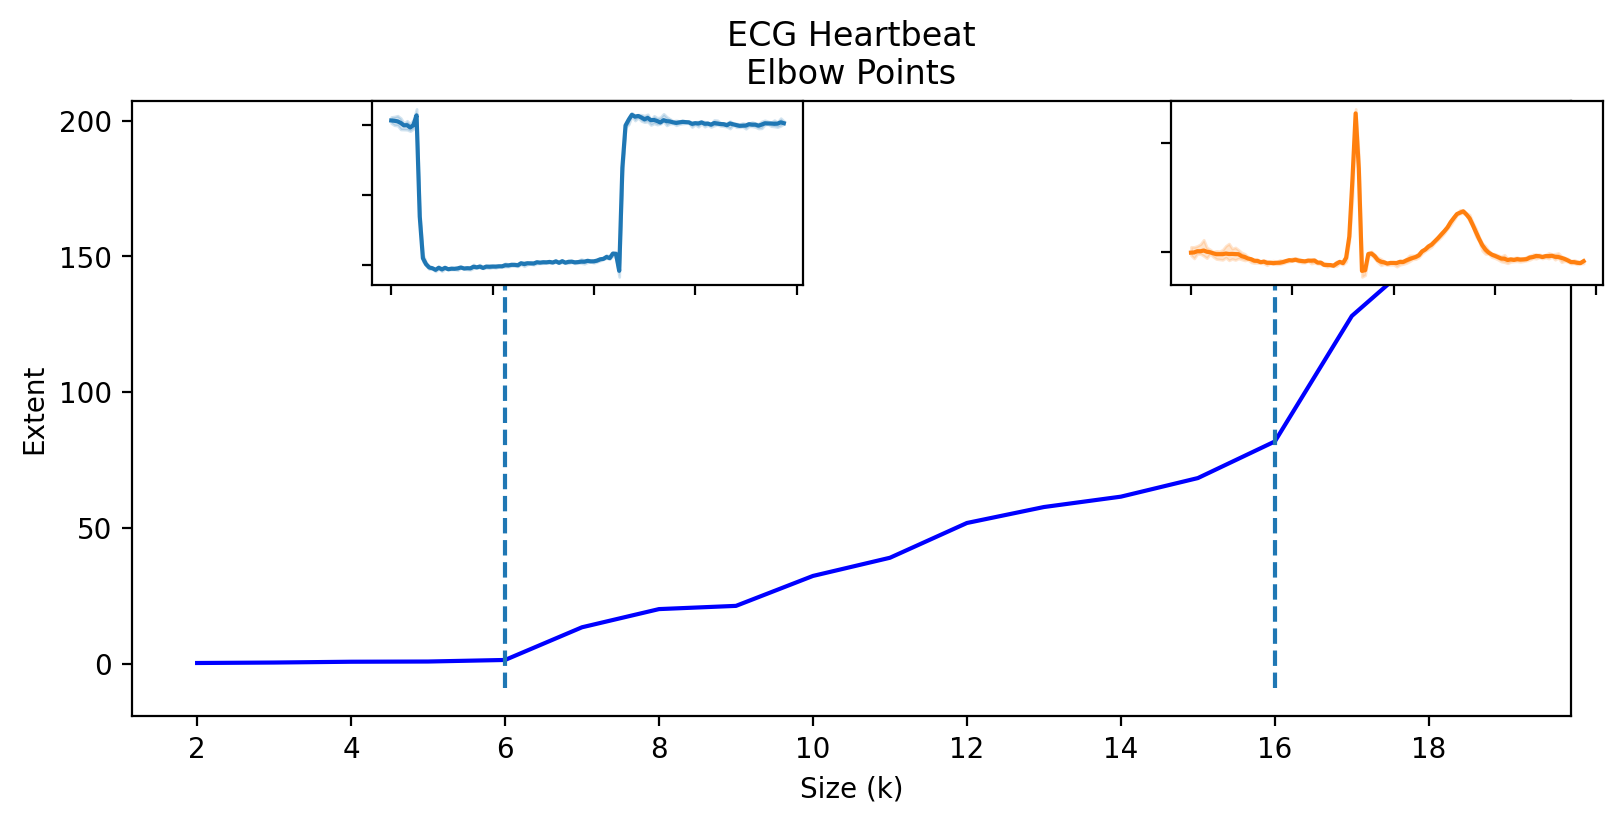

Data 3000


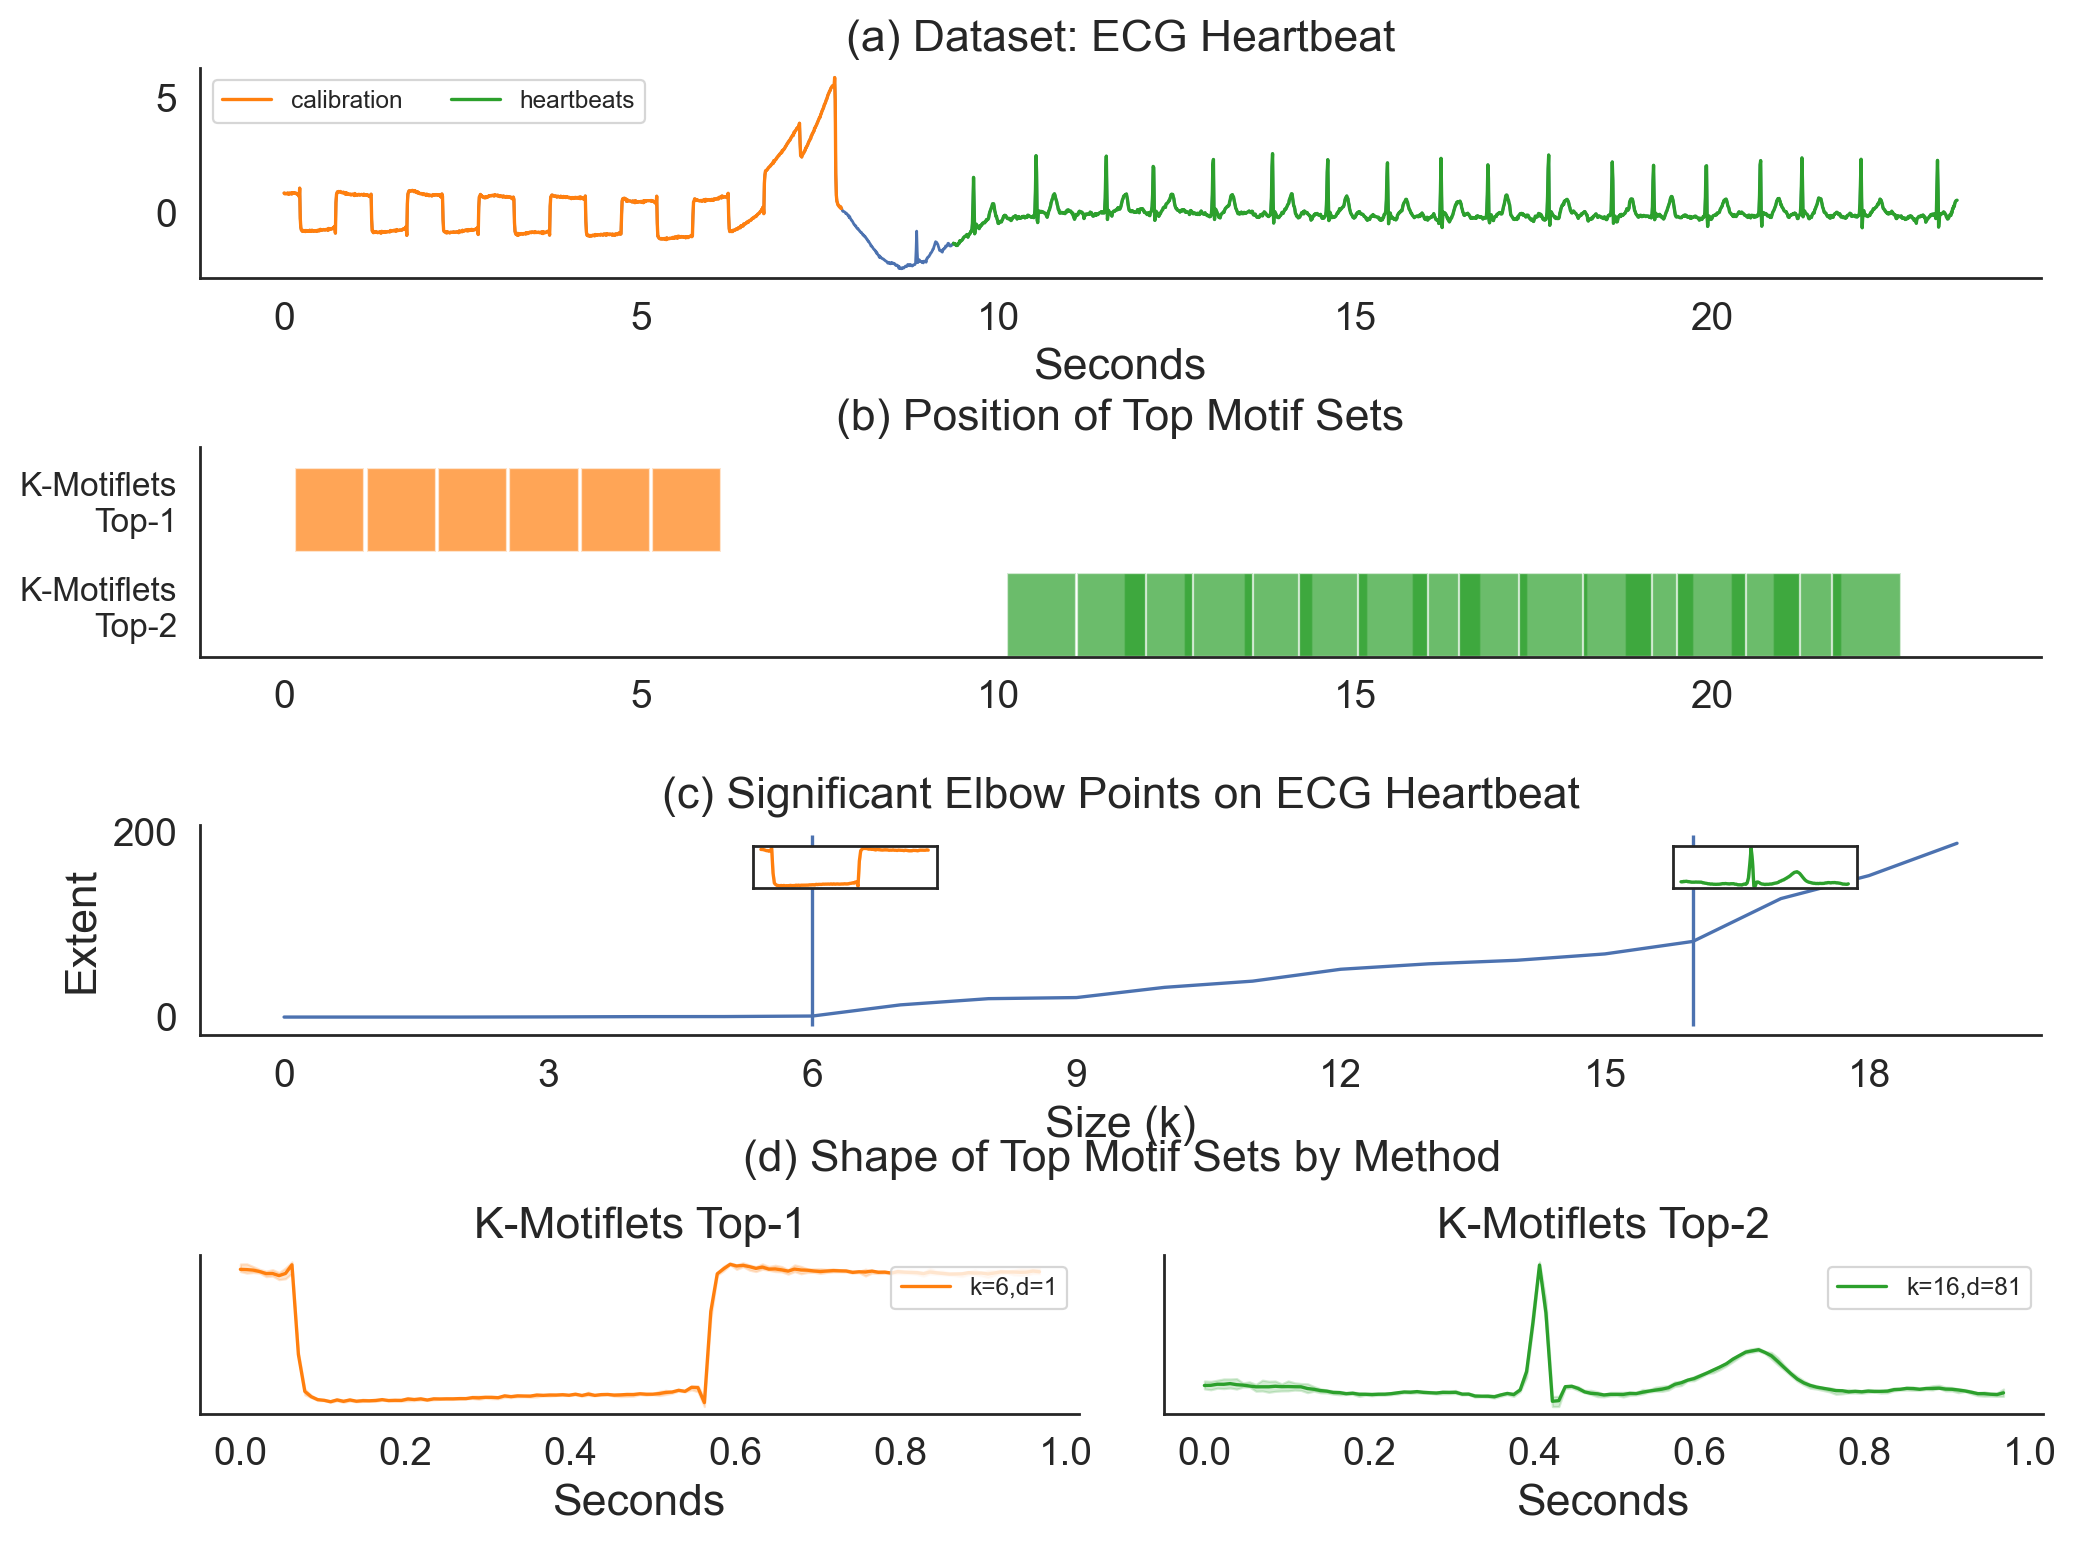

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets", ground_truth=df_gt)

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. 

We use the results of $k$-Motiflets as silver standard and compare the ability of the other methods to recover the respective motifs. To enable such a comparison, we provided the competitors with proper values of $r$ and $l$, derived from the silver standard, but also with an added noise of $-10\%$ and $+10\%$ to reflect trial-and-error tuning.

In [6]:
data = series.values
D_full = ml.compute_distances_full(data, motif_length)
df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])

print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top2, r_top1])
print("Radii r", radii)
print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radius r of TOP-2 Motifs 55.67435836791992 0.6736138463020325
Extent d of TOP-1 Motif 81.79418182373047
Radii r [ 0.67361385 55.67435837]
Best Radii	 [ 0.67361385 55.67435837]
Best Lengths	 125


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
rs = np.array([r_top2*10, r_top1*1.5])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

Now, we show the found motifs

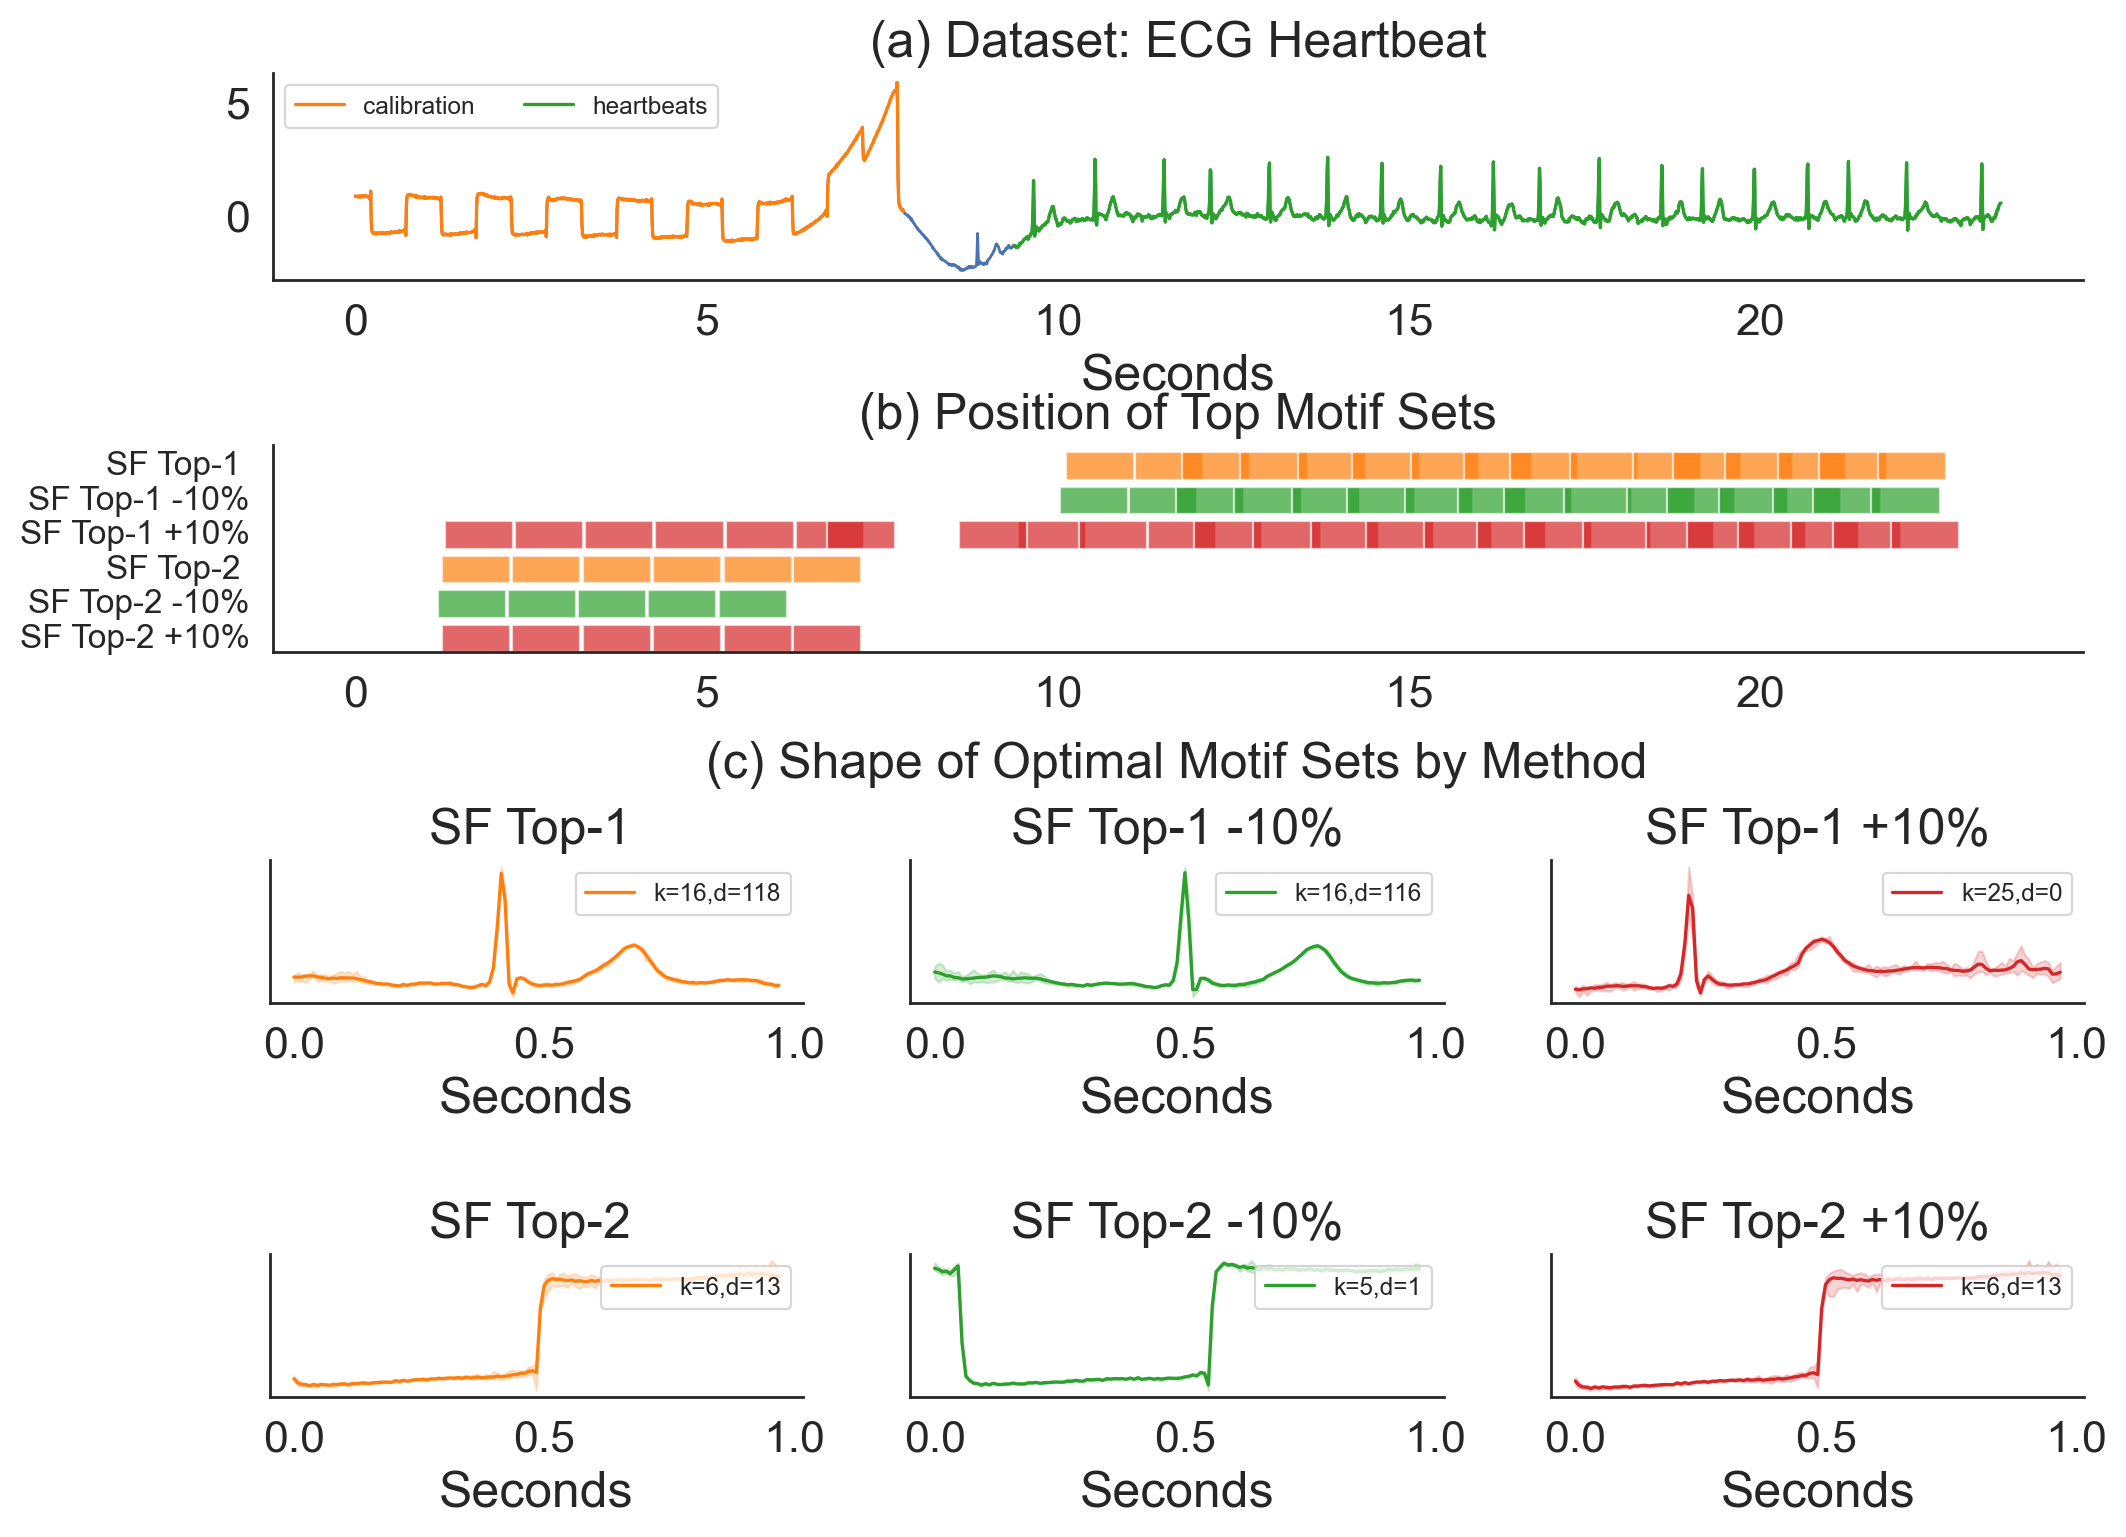

In [8]:
# run jave code first       
ms_all = {
    "" : [
    [671, 158, 286, 414, 542, 798],
	[1421, 1295, 1506, 1612, 1718, 1817, 1924, 2021, 2105, 2213, 2328, 2402, 2496, 2593, 2668, 2774],
    ], 
    "-10%" :[
    [406, 150, 278, 534, 662],
	[1410, 1284, 1495, 1601, 1707, 1807, 1913, 2010, 2094, 2202, 2317, 2391, 2486, 2583, 2657, 2763],
    ],   
    "+10%" :[
    [671, 158, 286, 414, 542, 798],
	[1207, 163, 291, 419, 547, 676, 803, 859, 1100, 1319, 1444, 1529, 1636, 1742, 1841, 1948, 2045, 2129, 2237, 2352, 2426, 2520, 2617, 2692, 2798],
    ]
}

motifsets = to_df(ms_all, "SF", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Set Finder (SF) finds all occurrences of the heartbeats and calibrations when given optimal parameters. However, when adding a small noise, a blurred TOP-1 motif is reported, which spans the whole time series.

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
rs = np.array([r_top2*10, r_top1*2.92])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

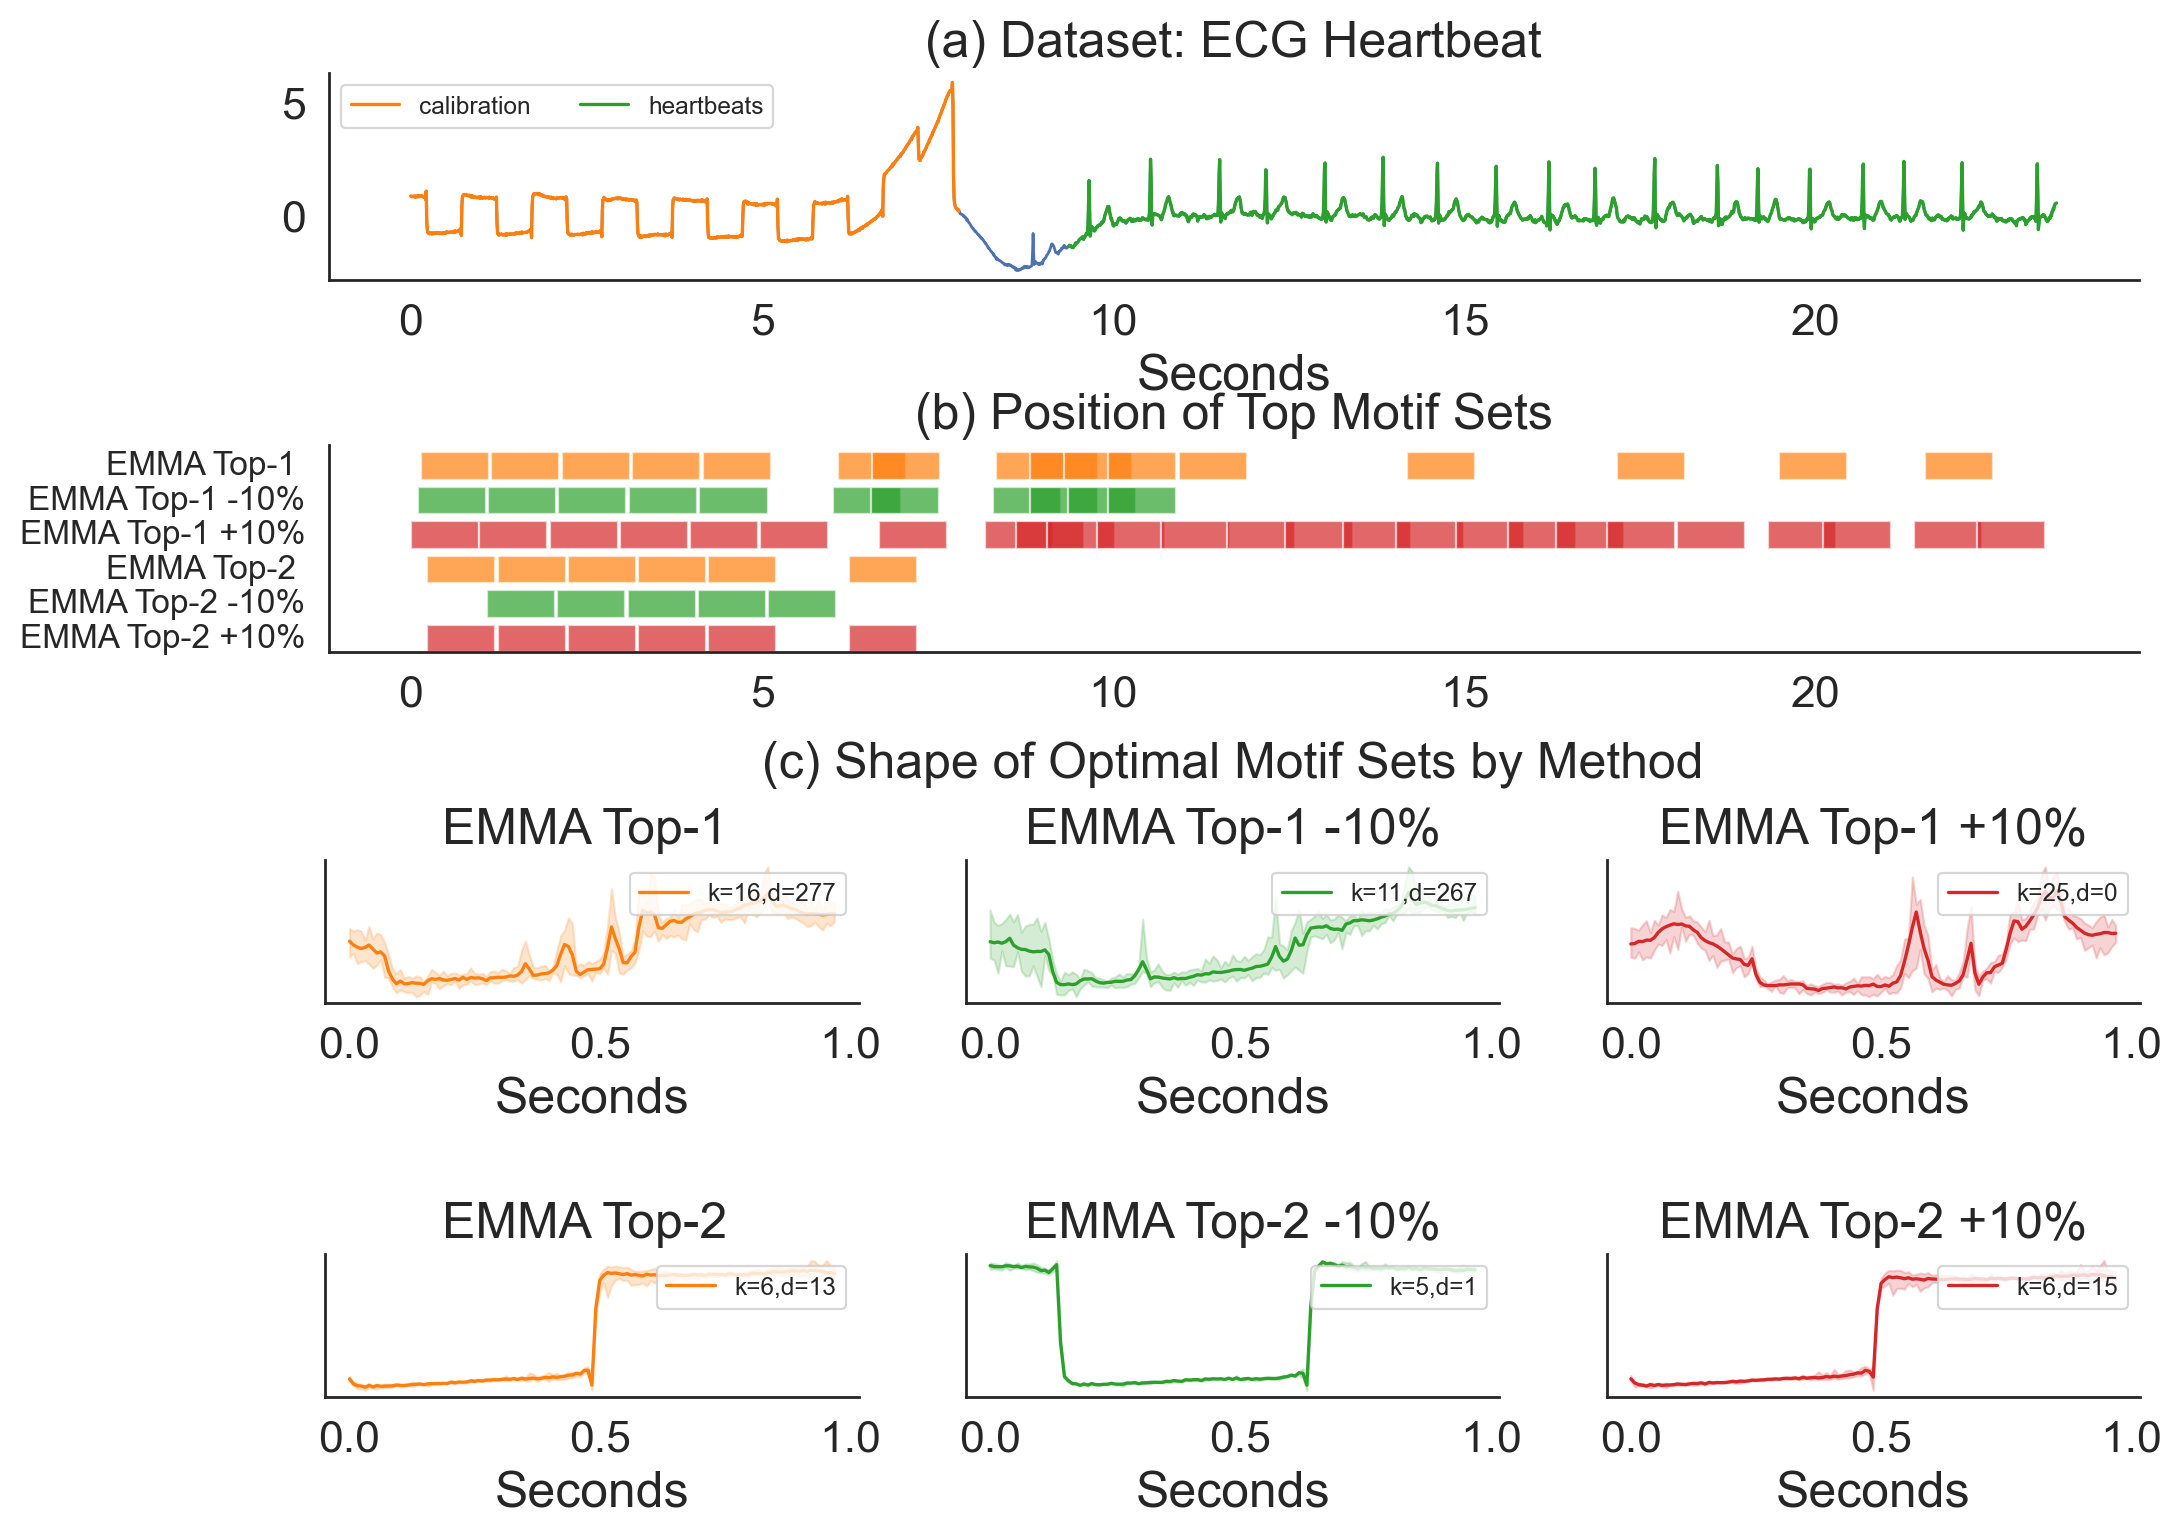

In [10]:
# run jave code first       
ms_all = {
    "" : [
    [30, 158, 286, 414, 542, 798],
	[19, 146, 275, 403, 532, 779, 841, 1067, 1129, 1191, 1271, 1399, 1816, 2198, 2493, 2760],
    ], 
    "-10%" :[
    [139, 267, 395, 523, 651],
	[13, 140, 269, 397, 526, 770, 838, 1061, 1129, 1197, 1270],
    ],
    "+10%" :[
    [30, 158, 286, 414, 542, 799],
	[0, 124, 253, 381, 509, 637, 854, 1047, 1103, 1159, 1250, 1368, 1488, 1593, 1699, 1796, 1905, 1999, 2087, 2180, 2308, 2474, 2573, 2740, 2855],    ]    
}


motifsets = to_df(ms_all, "EMMA", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)



EMMA's results heavily depend on the parameterization and a small change results in different motifs. EMMA only returns blurred version of the calibration signal as top-1 motif irrespective of the parameterization, but finds the top-2 motif. The ECG signal seems to be hidden.

# Valmod Motif Sets
based on own (fixed-length) implementation

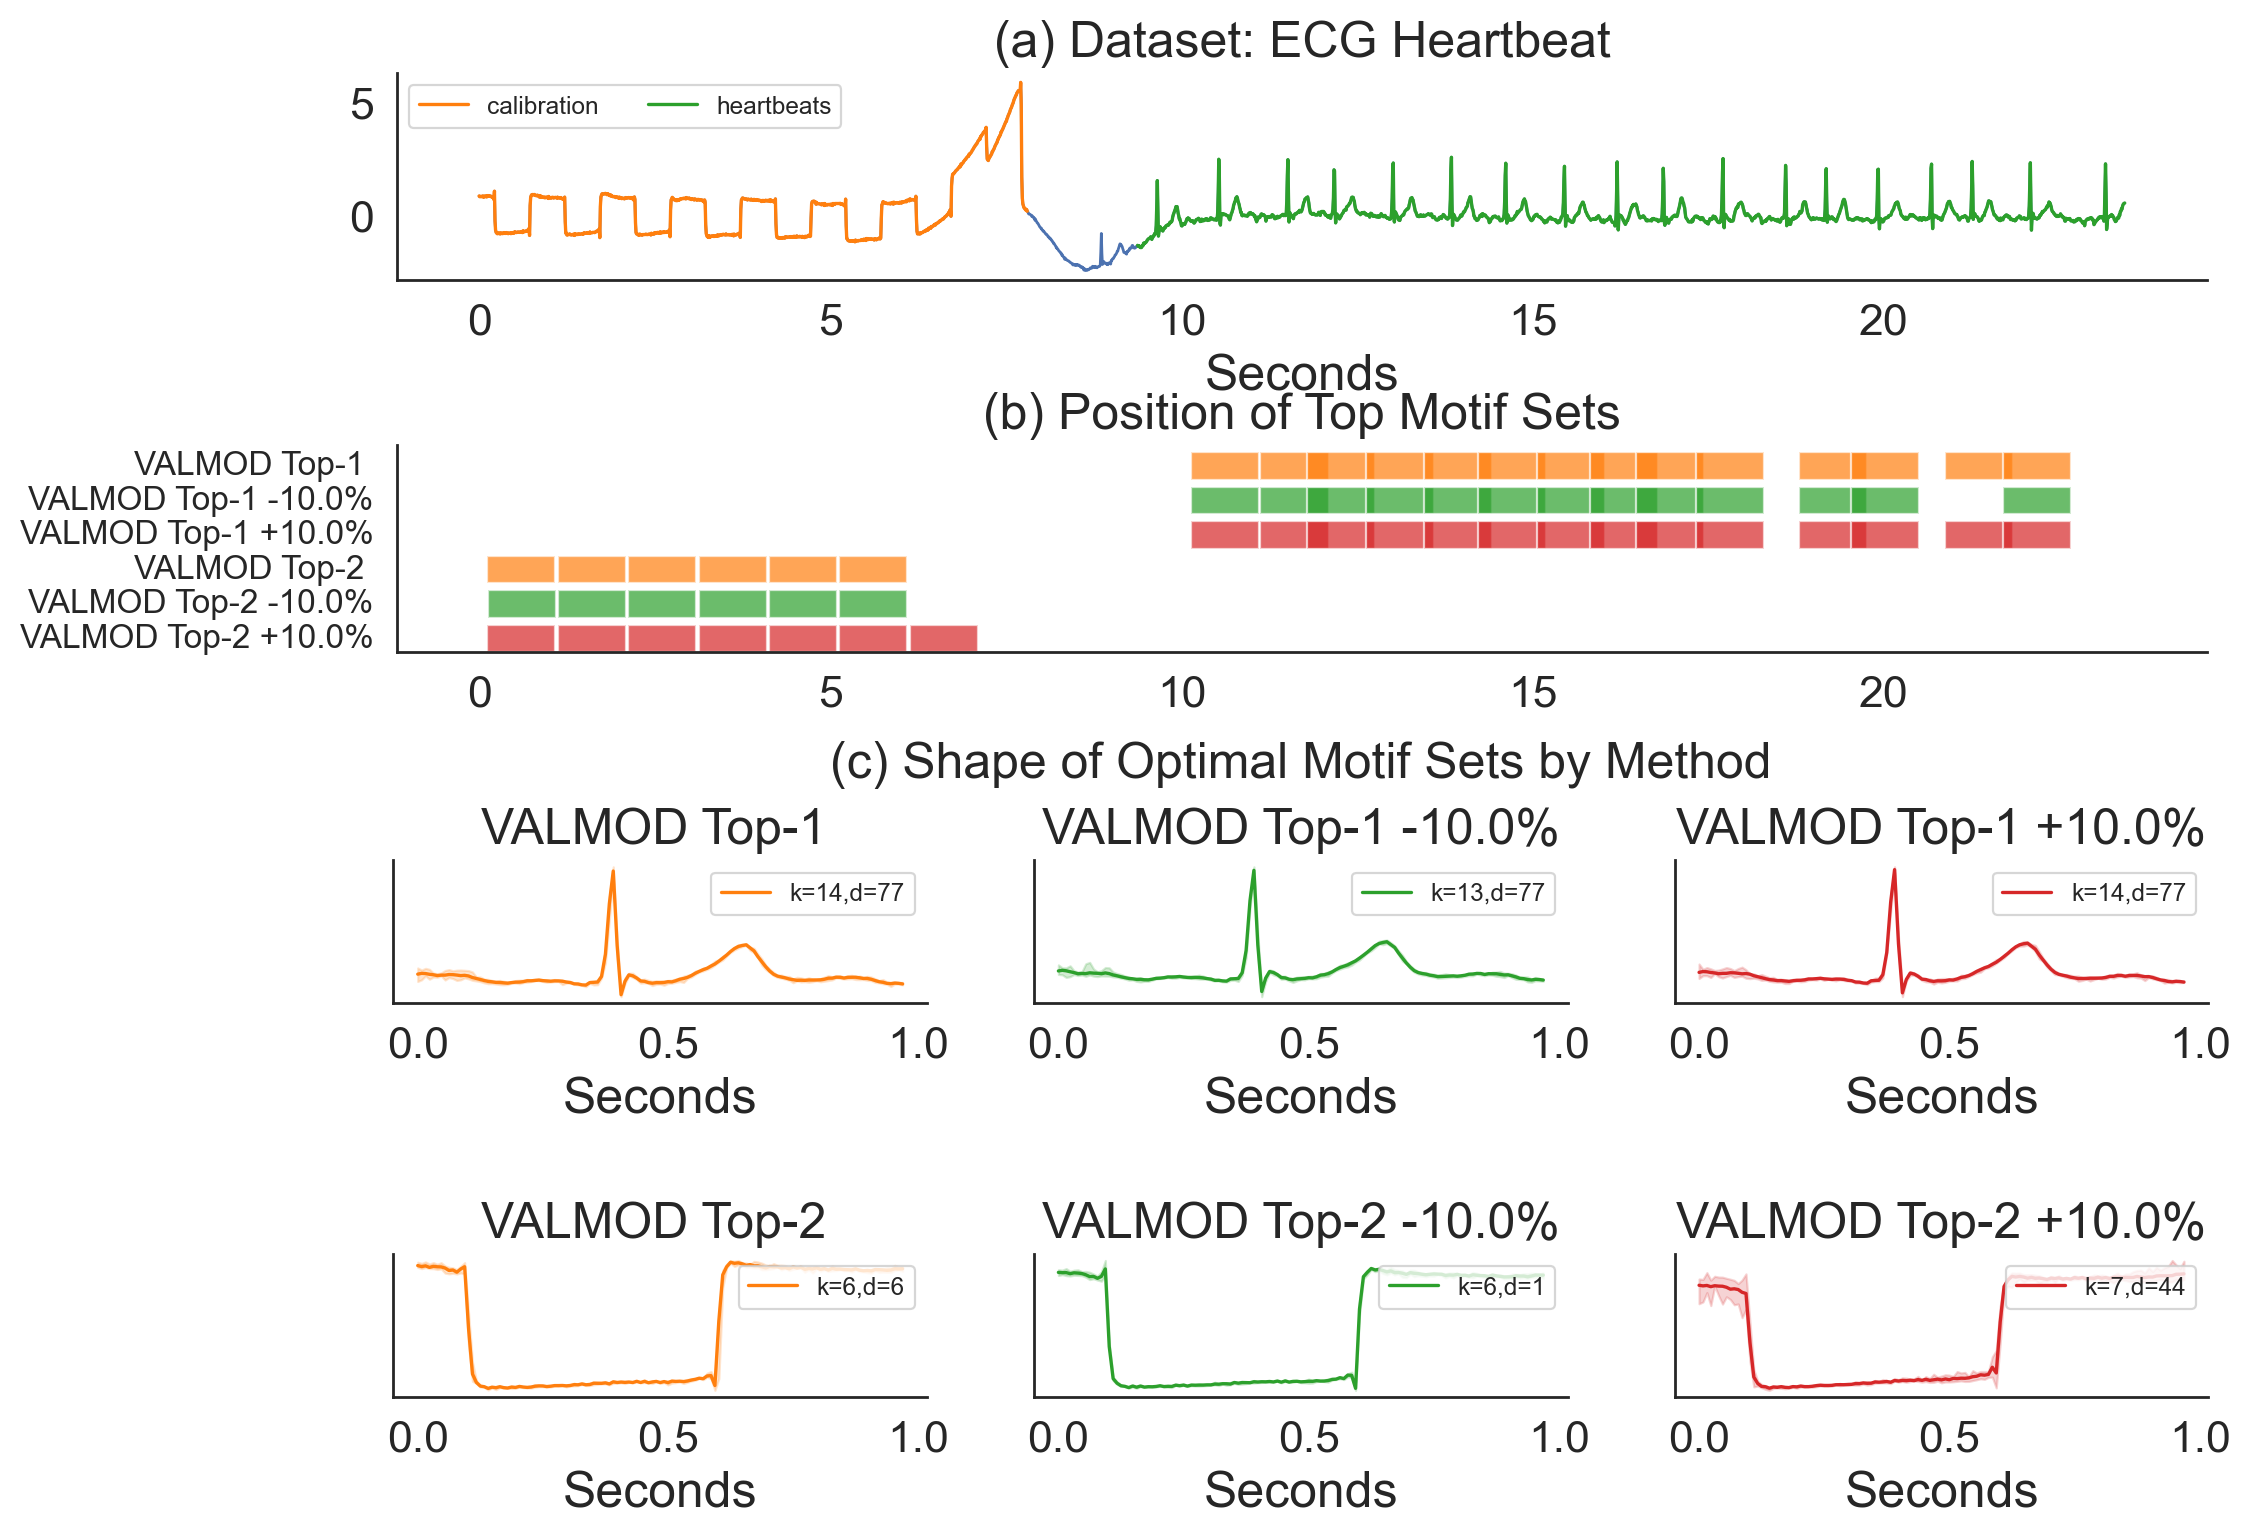

In [11]:
mls = motif_length
max_r=r_top1 * 4.0

ms_all = {}
for e in errors:
    rs = max_r * (1.0 * (1+e))
    #mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=rs))
    ms_all[format_key(e)] = ms_valmod
    
    
motifsets = to_df(ms_all, "VALMOD", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


VALMOD finds both the ECG signal and the calibration signal when given correct parameterization. It fails to recover all occurences of the ECG signal though with only 14 out of 16 occurences at most.

# Learning Motifs
See Java Code

In [12]:
rs = np.array([r_top2+8, r_top1*1.])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

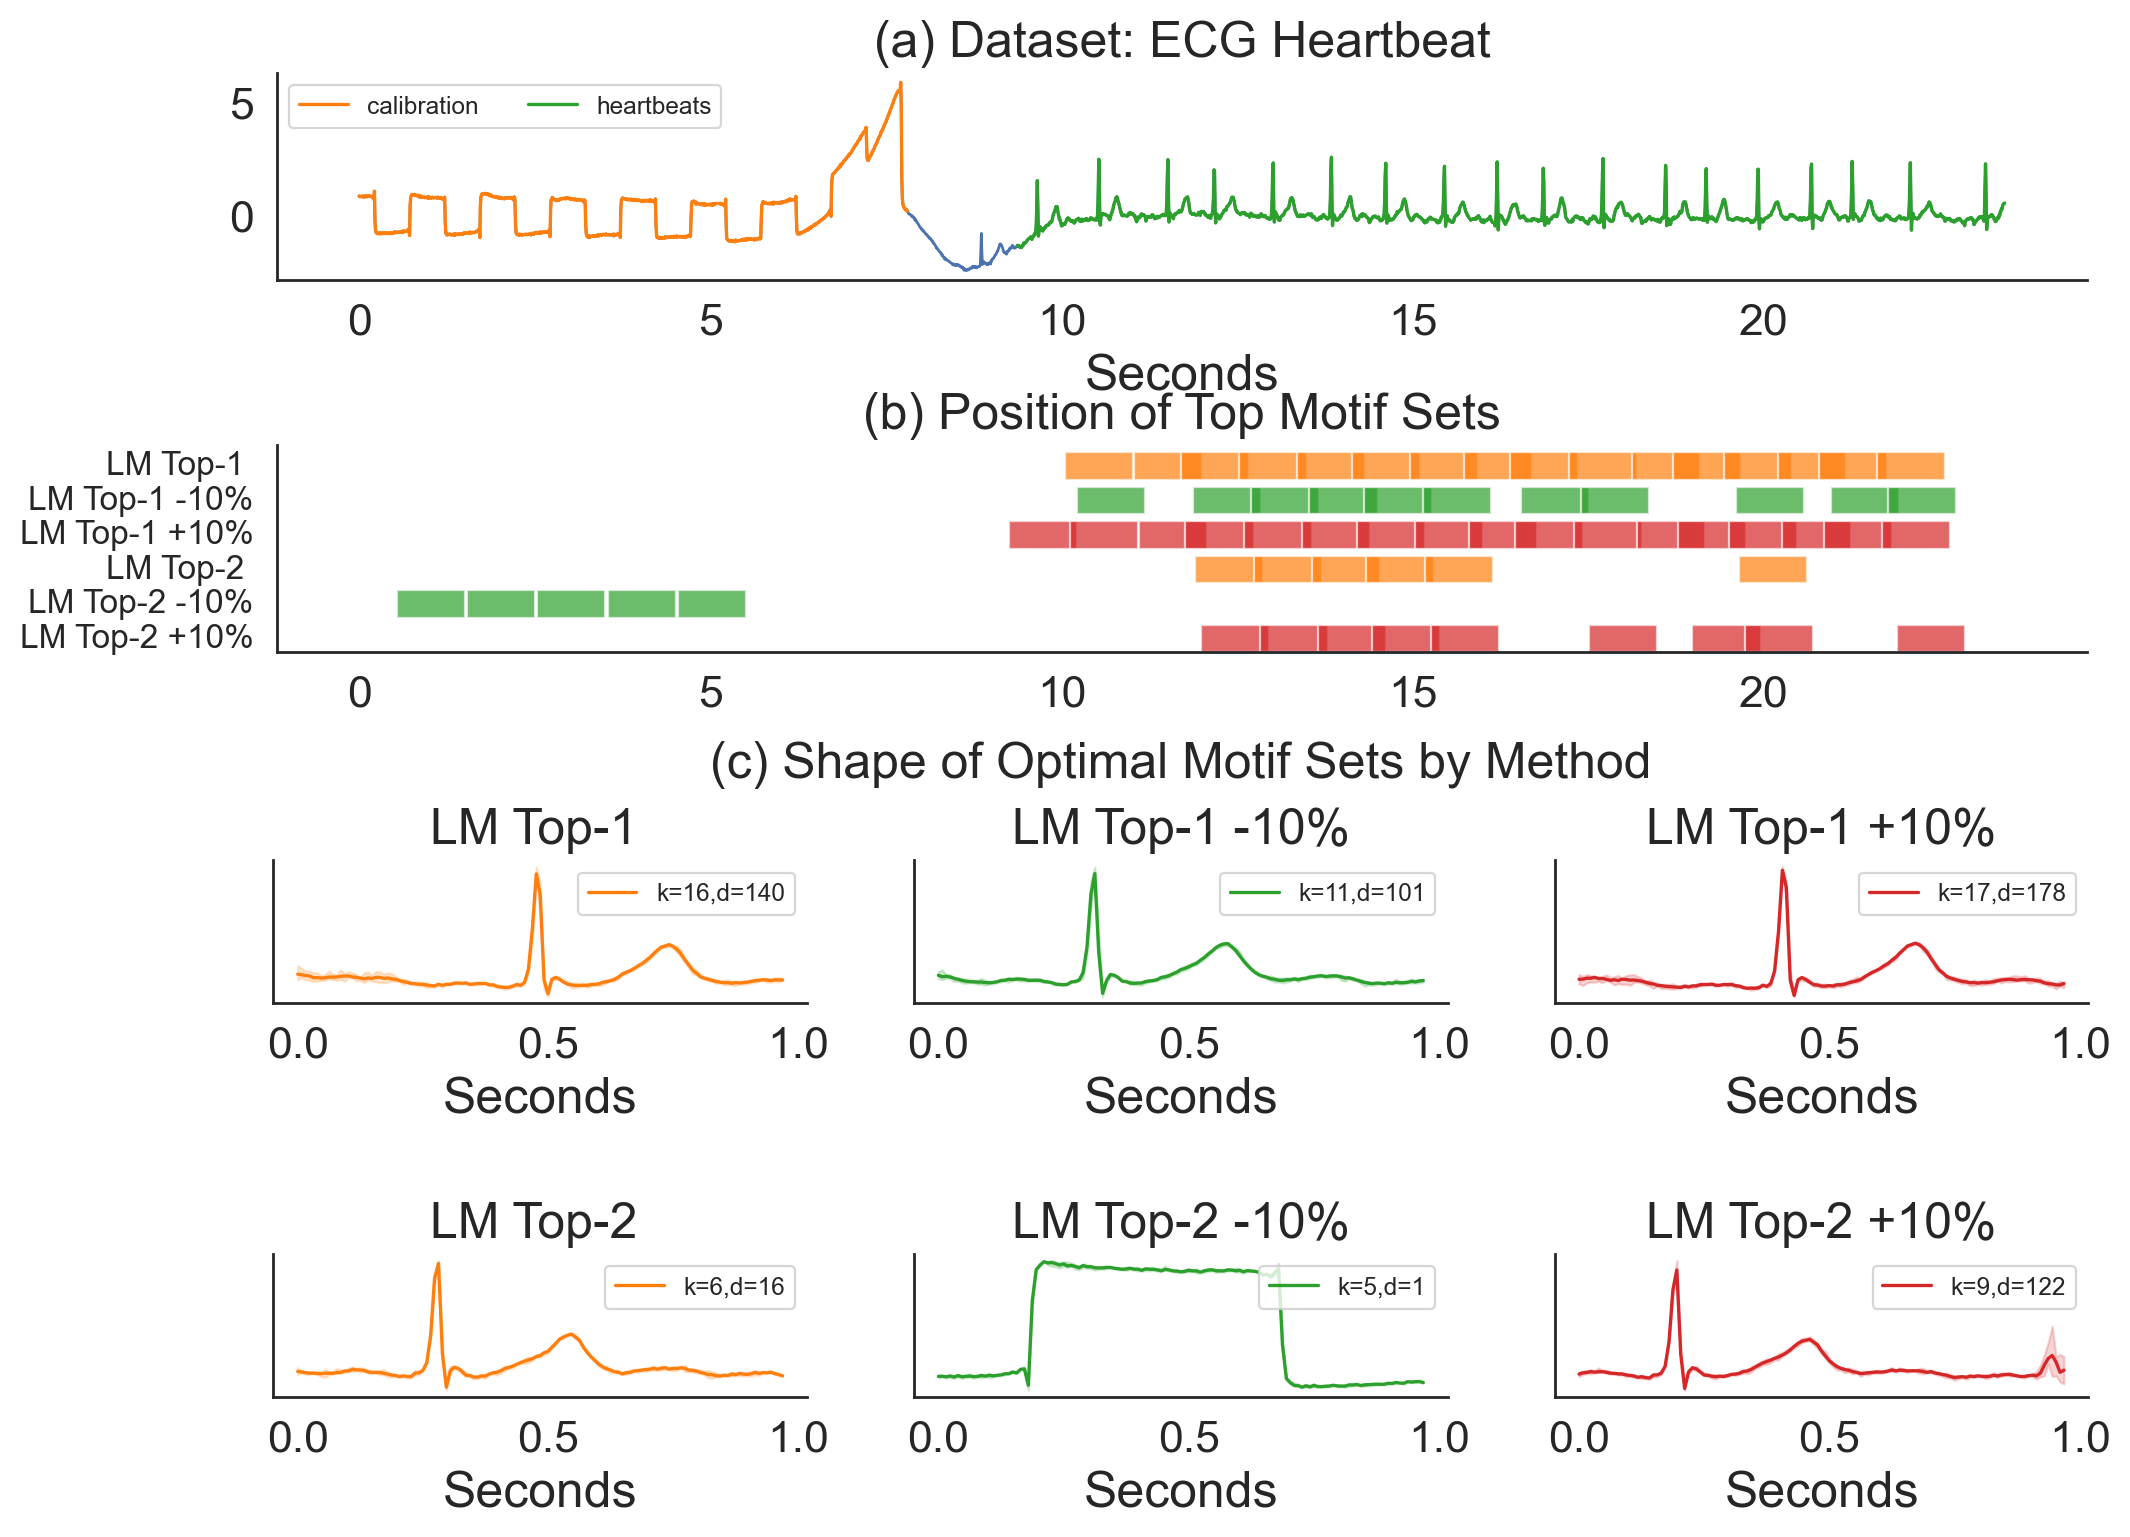

In [13]:
ms_all = {
    "" : [
        [1523,1630,1736,1835,1942,2514,],
        [1287,1412,1498,1604,1710,1809,1916,2013,2097,2205,2320,2394,2488,2585,2660,2766],
    ], 
    "-10%" : [    
        [69,197,325,453,581,],
        [1308,1519,1626,1732,1831,1938,2118,2227,2510,2682,2787,],
    ],        
    "+10%" : [
        [1534,1641,1747,1846,1953,2242,2430,2525,2802,],
        [1184,1296,1421,1506,1613,1719,1818,1925,2022,2106,2214,2329,2403,2497,2594,2669,2775,],
    ],
}


motifsets = to_df(ms_all, "LM", df, df2)
plot_all_competitors(series, ds_name, motifsets.offsets.values, motif_length,
                     method_names=motifsets.index.values, ground_truth=df_gt)


Results of LM depend heavily on parameterization and initialization of the stochastic gradient descent (SGD). 
LM only found the heartbeats as TOP motifs, or at most k=$5$ calibrations as TOP-2 when changing parameterization and doing multiple runs of SGD.

# Comparison

We next show a comparison of all methods.

Note that the k-Motiflet algorithm has to recover meaningful motifs without any additional knowledge, while the competitors were provided with inputs with near-optimal parameters, and their results rely heavily on parameterization.

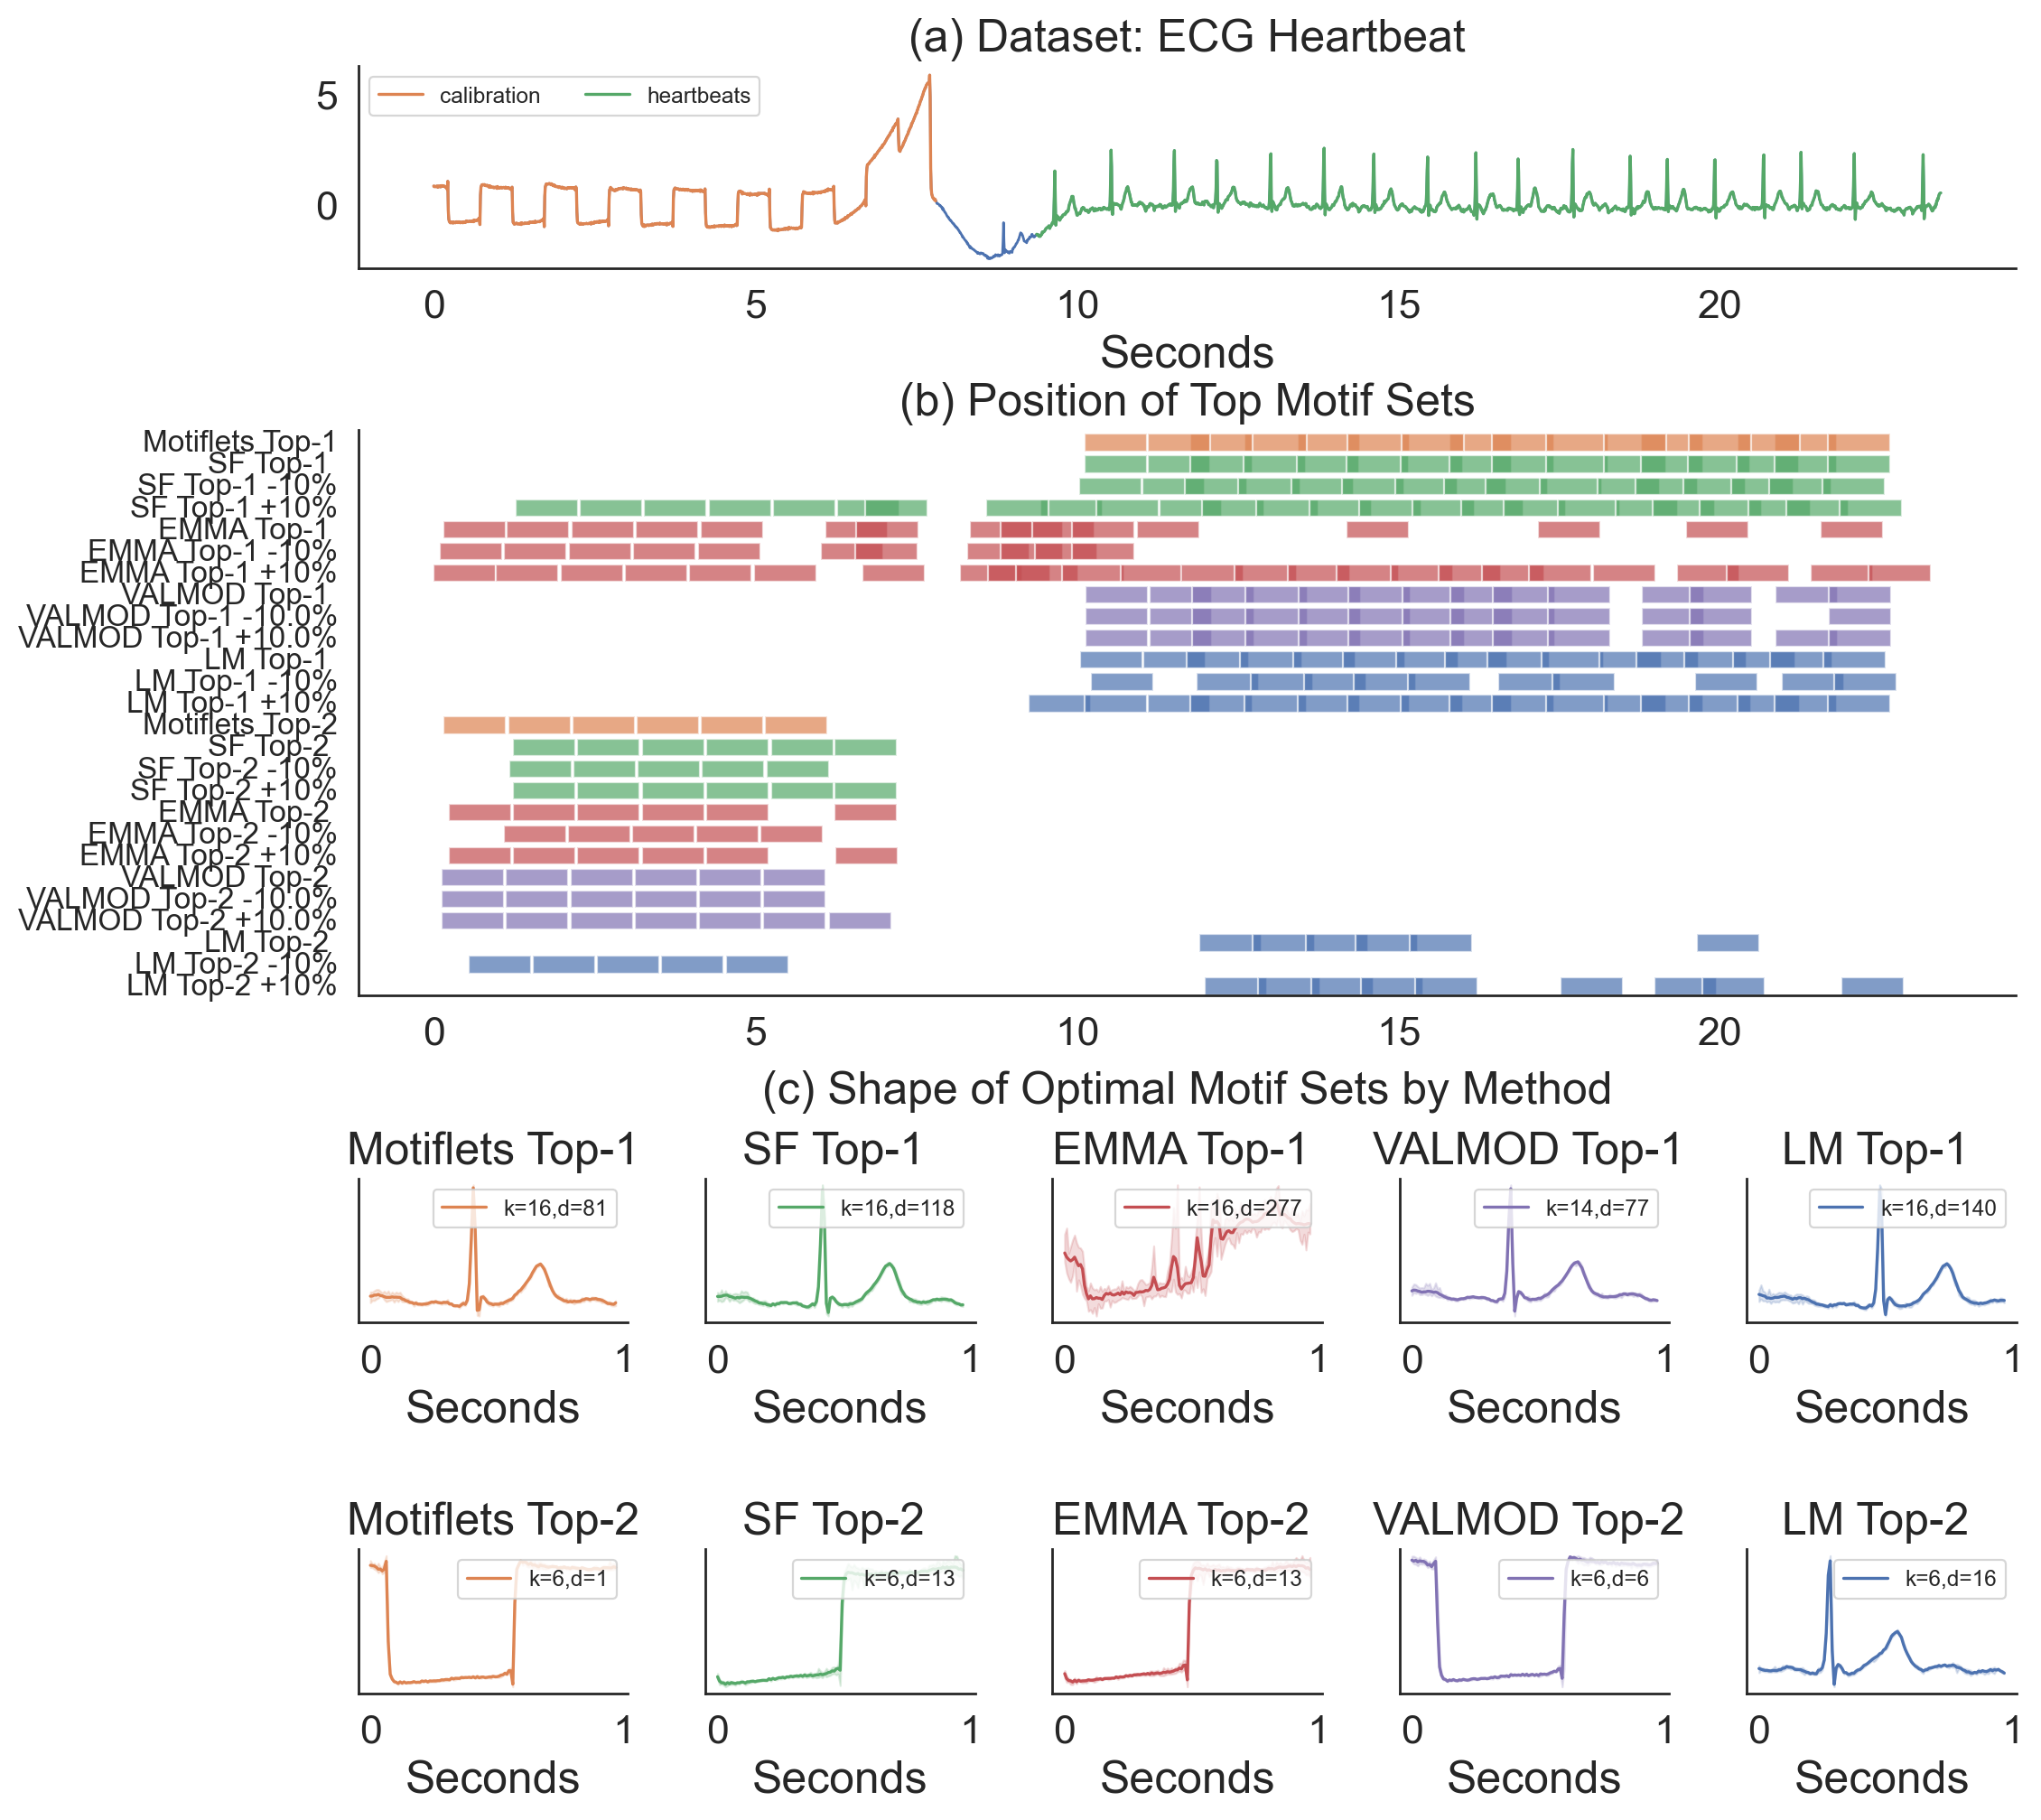

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            

The bottom part of the plot only shows the shape of the optimal motifs, i.e. with optimal parameterization.

Only $k$-Motiflets and SF and VALMOD clearly identify both motifs (ECG and calibration). The $k$-Motiflet algorithm recovered meaningful motifs without any additional knowledge, while VALMOD and SF were provided with inputs with near-optimal parameters. 